# Dataset AirPassengers

### Pendahuluan

Data yang digunakan adalah kompilasi penumpang dari Januari 1949 hingga Desember 1960. Saya ingin memprediksi deret waktu melalui model RNN yang dibuat dari LTSM sederhana untuk data tersebut.

**Apa itu analisis Time series?**               

Analisis deret waktu mencakup metode untuk menganalisis data deret waktu guna mengekstraksi statistik yang bermakna dan karakteristik lain dari data tersebut. Peramalan deret waktu adalah penggunaan model untuk memperkirakan nilai masa depan berdasarkan nilai yang diamati sebelumnya. Meskipun analisis regresi sering digunakan sedemikian rupa untuk menguji hubungan antara satu atau beberapa deret waktu yang berbeda, jenis analisis ini biasanya tidak disebut "analisis deret waktu", yang secara khusus merujuk pada hubungan antara titik waktu yang berbeda dalam satu deret. Analisis deret waktu terputus digunakan untuk mendeteksi perubahan dalam evolusi deret waktu dari sebelum hingga setelah beberapa intervensi yang dapat memengaruhi variabel yang mendasarinya.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import statsmodels
import statsmodels.api as sm  


from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from torch import nn
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
df=pd.read_csv('../Data/AirPassengers.csv')
cm = sns.light_palette("green", as_cmap=True)
df.head(20).style.background_gradient(cmap=cm)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [5]:
print(df.describe())
print('-'*40)
print(df.tail())

       #Passengers
count   144.000000
mean    280.298611
std     119.966317
min     104.000000
25%     180.000000
50%     265.500000
75%     360.500000
max     622.000000
----------------------------------------
       Month  #Passengers
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432


In [6]:
df.shape

(144, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


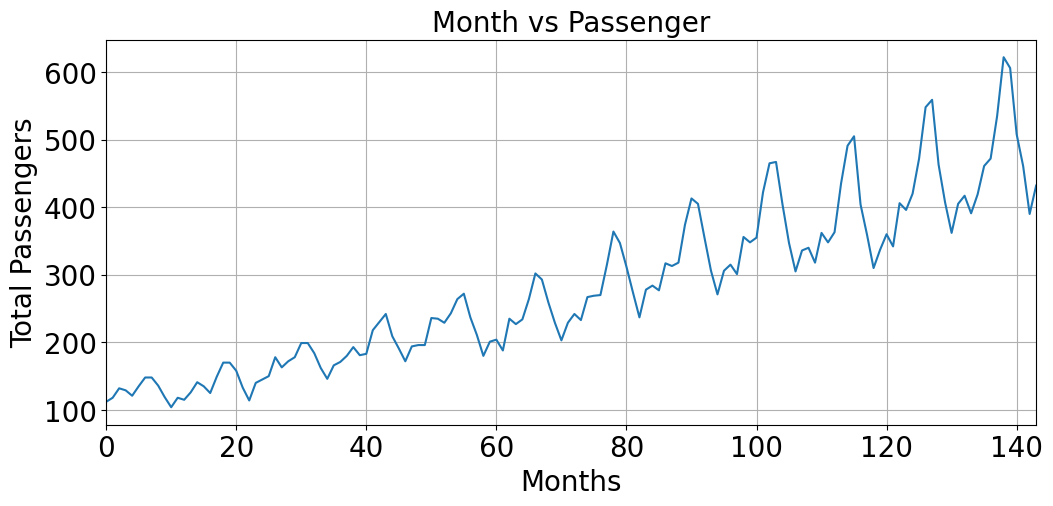

In [8]:
plt.figure(figsize=(12,5))
plt.title('Month vs Passenger',fontsize = 20)
plt.ylabel('Total Passengers',fontsize = 20)
plt.xlabel('Months',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(df['#Passengers'])

In [9]:
df['#Passengers']

0      112
1      118
2      132
3      129
4      121
      ... 
139    606
140    508
141    461
142    390
143    432
Name: #Passengers, Length: 144, dtype: int64

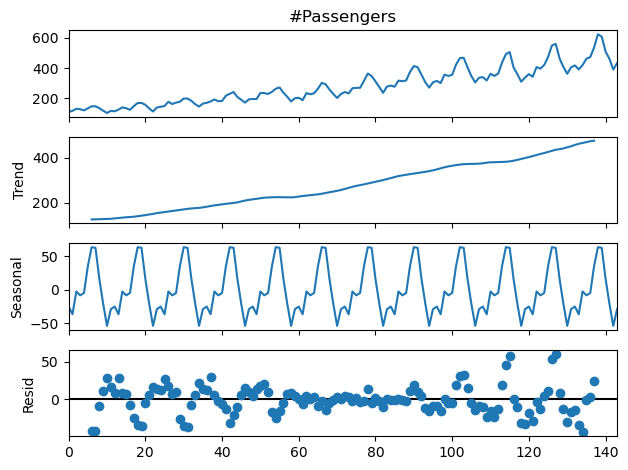

In [ ]:
decomposition = seasonal_decompose(df['#Passengers'], period=12) 

decomposition.plot()
plt.show()

In [11]:
all_data = df['#Passengers'].values.astype(float)
print(all_data)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


In [12]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [13]:
print(len(train_data))
print(len(test_data))

132
12


In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

# Fungsi Utilitas

1. Fungsi ini mengembalikan tuple dengan mengubah data masukan mentah menjadi data sekuens agar sesuai dengan pelatihan. Jumlah penumpang yang bepergian dalam 12 bulan pertama memprediksi jumlah penumpang dalam 13 bulan.

2. Nilai pertama dalam tuple: sekuens penumpang dalam 12 bulan (=fitur)

3. Nilai kedua dari tuple: jumlah penumpang yang diprediksi sebagai jumlah penumpang dalam 12 bulan (=target)

In [15]:
train_window = 12

def create_inout_sequences(input_data, window):
    inout_seq = []
    L = len(input_data)
    for i in range(L-window):
        train_seq = input_data[i:i+window]
        train_label = input_data[i+window:i+window+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [16]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]),
  tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]),
  tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]),
  tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]),
  tensor([-0.9077]))]

## Apa Itu LTSM

Long short-term memory (LSTM) adalah arsitektur recurrent neural network (RNN)  yang digunakan dalam bidang deep learning. Tidak seperti jaringan saraf umpan maju standar, LSTM memiliki koneksi umpan balik. Ia dapat memproses tidak hanya titik data tunggal (seperti gambar), tetapi juga seluruh rangkaian data (seperti ucapan atau video). Misalnya, LSTM berlaku untuk tugas-tugas seperti pengenalan tulisan tangan yang tidak tersegmentasi dan terhubung, pengenalan ucapan, dan deteksi anomali dalam lalu lintas jaringan atau IDS (sistem deteksi intrusi).

Unit LSTM umum terdiri dari sel, gerbang masukan, gerbang keluaran, dan gerbang lupa. Sel mengingat nilai-nilai selama interval waktu yang berubah-ubah dan ketiga gerbang mengatur aliran informasi ke dalam dan ke luar sel.

Jaringan LSTM sangat cocok untuk mengklasifikasikan, memproses, dan membuat prediksi berdasarkan data deret waktu, karena mungkin ada jeda durasi yang tidak diketahui antara peristiwa-peristiwa penting dalam deret waktu. LSTM dikembangkan untuk menangani masalah gradien menghilang yang dapat ditemui saat melatih RNN tradisional. Ketidakpekaan relatif terhadap panjang celah merupakan keuntungan LSTM dibandingkan RNN, model hidden Markov, dan metode sequence learning lain dalam berbagai aplikasi.

In [17]:
from torch import nn
import torch.nn.functional as F

In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=128, num_layers=2, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq) ,1, -1))
        predictions = self.linear(lstm_out[:,-1,:])
        return predictions[-1]

In [19]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [20]:
print(model)

LSTM(
  (lstm): LSTM(1, 128, num_layers=2)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


## Training

In [21]:
epochs = 500

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
 
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

epoch:   1 loss: 0.01084834
epoch:  26 loss: 0.27766538
epoch:  51 loss: 0.27863944
epoch:  76 loss: 0.27870628
epoch: 101 loss: 0.28522071
epoch: 126 loss: 0.00002644
epoch: 151 loss: 0.00013047
epoch: 176 loss: 0.00011748
epoch: 201 loss: 0.00001586
epoch: 226 loss: 0.00001028
epoch: 251 loss: 0.00590088
epoch: 276 loss: 0.00000121
epoch: 301 loss: 0.00096390
epoch: 326 loss: 0.00001376
epoch: 351 loss: 0.00012289
epoch: 376 loss: 0.00275502
epoch: 401 loss: 0.00000510
epoch: 426 loss: 0.00284152
epoch: 451 loss: 0.00000202
epoch: 476 loss: 0.01194237
epoch: 499 loss: 0.00000278


In [22]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [23]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        test_inputs.append(model(seq).item())

In [24]:
test_inputs[fut_pred:]

[0.6224388480186462,
 0.7667601704597473,
 0.286391019821167,
 0.12752558290958405,
 0.10429354012012482,
 0.2944953441619873,
 0.5922313928604126,
 0.8355753421783447,
 0.4058903455734253,
 0.19194437563419342,
 0.03372800350189209,
 0.23023851215839386]

In [25]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[473.10483792]
 [505.93793878]
 [396.65395701]
 [360.51207011]
 [355.22678038]
 [398.4976908 ]
 [466.23264188]
 [521.59339035]
 [423.84005362]
 [375.16734546]
 [339.1731208 ]
 [383.87926152]]


In [26]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


# Memeriksa hasil
Prediksi LSTM ditunjukkan oleh garis oranye. Meskipun hasilnya tidak akurat, tren kenaikan dapat terlihat berdasarkan fluktuasi jumlah total penumpang yang bepergian selama 12 bulan terakhir. Performa yang lebih baik dapat dicapai dengan menggunakan lebih banyak periode dan lebih banyak neuron di lapisan LSTM.

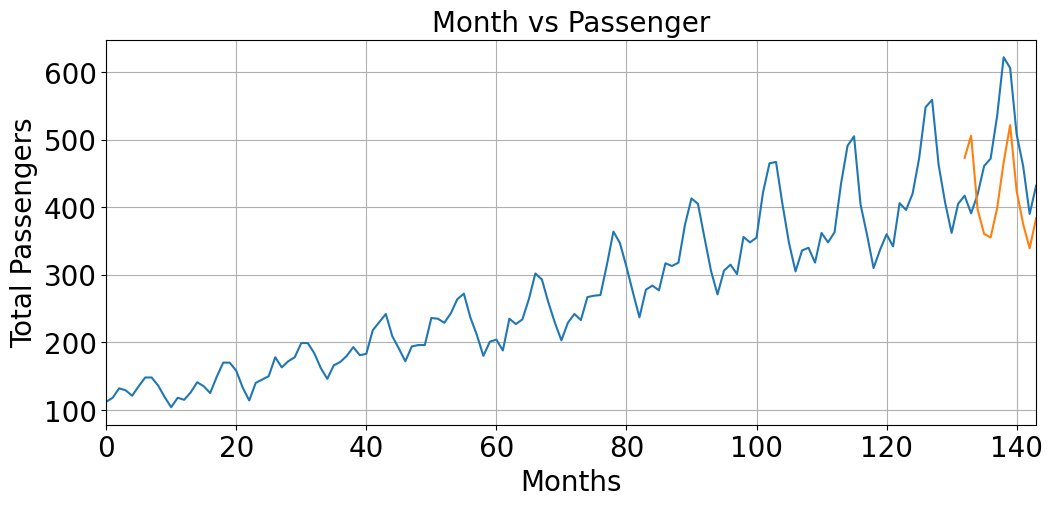

In [27]:
plt.figure(figsize=(12,5))
plt.title('Month vs Passenger',fontsize = 20)
plt.ylabel('Total Passengers',fontsize = 20)
plt.xlabel('Months',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(df['#Passengers'])
plt.plot(x,actual_predictions)

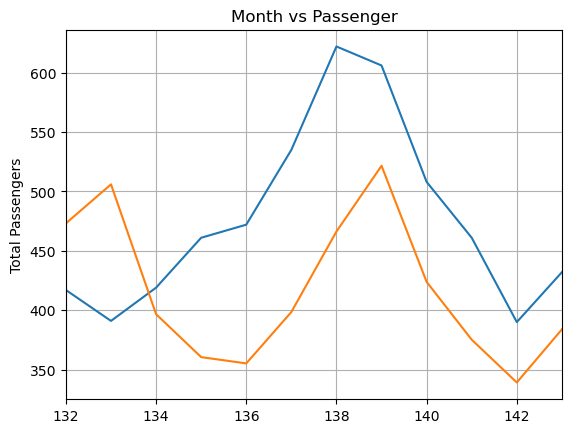

In [28]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(df['#Passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()

In [29]:
df['#Passengers'][:-train_window]
train_df = pd.DataFrame(df['#Passengers'][:-train_window])
actual_df = pd.DataFrame(actual_predictions)
actual_df.columns = ['#Passengers']
new_predict = pd.concat([train_df,actual_df]).reset_index(drop=True)

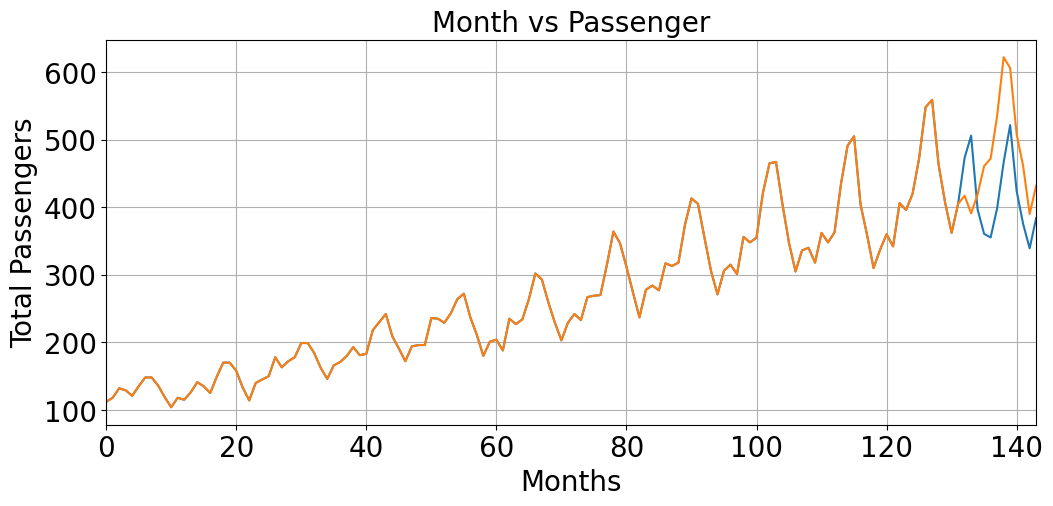

In [30]:
plt.figure(figsize=(12,5))
plt.title('Month vs Passenger',fontsize = 20)
plt.ylabel('Total Passengers',fontsize = 20)
plt.xlabel('Months',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(new_predict)
plt.plot(df['#Passengers'])

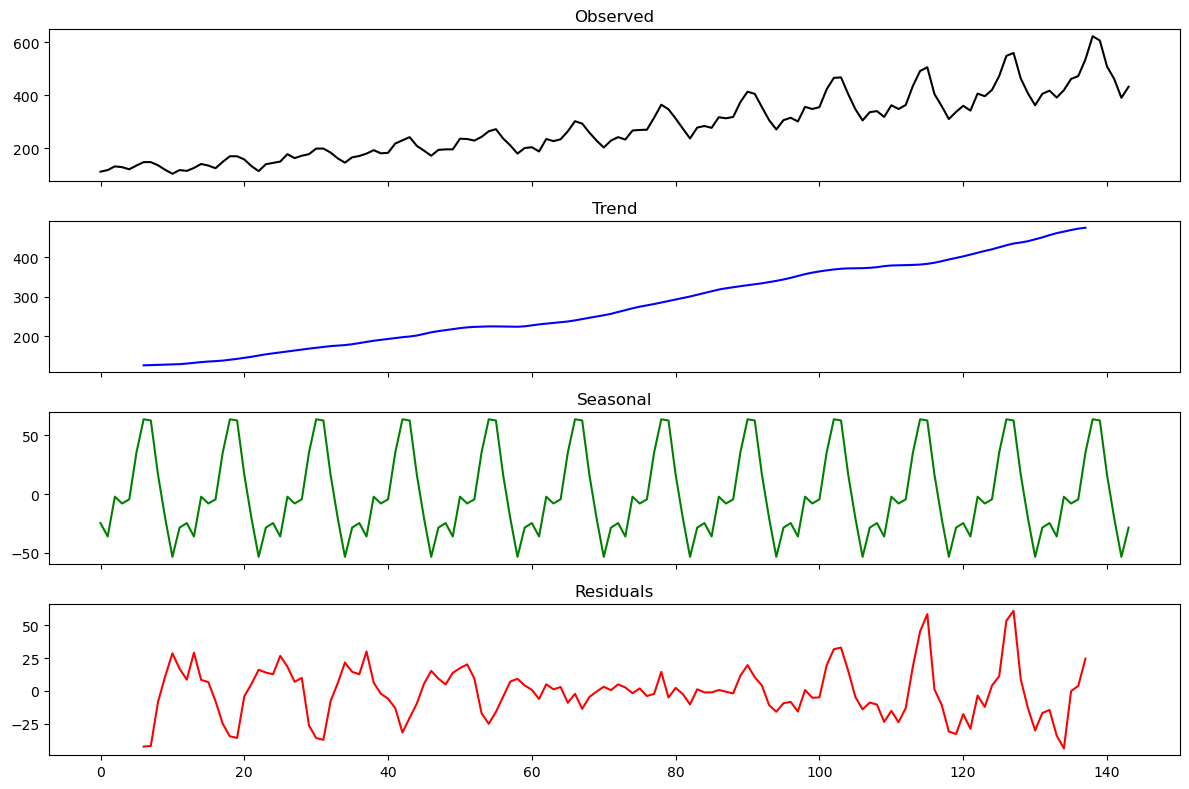

In [31]:
def plot_decompose(decomposition):
    fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
    
    decomposition.observed.plot(ax=axes[0], title='Observed', color='black')
    decomposition.trend.plot(ax=axes[1], title='Trend', color='blue')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal', color='green')
    decomposition.resid.plot(ax=axes[3], title='Residuals', color='red')
    
    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk plot hasil dekomposisi
plot_decompose(decomposition)


## Prediksi by Prophet

### Preprocessing

In [32]:
df = df.copy()

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [34]:
# Konversi kolom 'Month' ke datetime dengan format '%Y-%m'
df['ds'] = pd.to_datetime(df['Month'], format='%Y-%m')

# Buat DataFrame final hanya dengan kolom 'ds' dan '#Passengers'
df_new = df[['ds', '#Passengers']].copy()
df_new.rename(columns={"#Passengers": "y"}, inplace=True)

print(df_new.head())
print(f"Total baris: {len(df_new)}")

          ds    y
0 1949-01-01  112
1 1949-02-01  118
2 1949-03-01  132
3 1949-04-01  129
4 1949-05-01  121
Total baris: 144


In [35]:
df.head(10)

,Month,#Passengers,ds
0,1949-01,112,1949-01-01
1,1949-02,118,1949-02-01
2,1949-03,132,1949-03-01
3,1949-04,129,1949-04-01
4,1949-05,121,1949-05-01
5,1949-06,135,1949-06-01
6,1949-07,148,1949-07-01
7,1949-08,148,1949-08-01
8,1949-09,136,1949-09-01
9,1949-10,119,1949-10-01


In [36]:
print(len(df_new))  # Harus 144

144


In [ ]:
from prophet import Prophet
m = Prophet()
m.fit(df_new)

14:26:21 - cmdstanpy - INFO - Chain [1] start processing
14:26:21 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
future = m.make_future_dataframe(periods=500)
forecast = m.predict(future)

In [39]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [40]:
plot_components_plotly(m, forecast)